In [21]:
try:
    already_initialized
except NameError:
    !python -m pip install --upgrade pip
    !pip install spacy==2.3.5
    !pip install spacy-lookups-data
    !python -m spacy download de_core_news_sm
    already_initialized = True

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import spacy
import de_core_news_sm
from spacy.lang.de import German
from spacy.matcher import PhraseMatcher
from spacy.gold import GoldParse
from spacy.scorer import Scorer

import random
import pprint
import string
import re
from datetime import datetime
from pathlib import Path

In [23]:
csv_file = 'data/data.csv'
ingredients_df = pd.read_csv(csv_file)

print(f"Total number of rows: {len(ingredients_df.index)}")

# print out the first few rows of data info
ingredients_df.head(10)

Total number of rows: 573


,ingredient,quantity,unit,name
0,2.00 Becher süße Sahne,2.00,Becher,süße Sahne
1,6.00 Blätter Basilikum,6.00,Blätter,Basilikum
2,4.00 Blätter Petersilie,4.00,Blätter,Petersilie
3,0.52 Bund Minze,0.52,Bund,Minze
4,0.52 Bund Petersilie,0.52,Bund,Petersilie
5,1.00 Bund Frühlingszwiebeln,1.00,Bund,Frühlingszwiebeln
6,0.52 Bund Petersilie,0.52,Bund,Petersilie
7,1.00 Bund Frühlingszwiebeln,1.00,Bund,Frühlingszwiebeln
8,1.00 Bund Koriander,1.00,Bund,Koriander
9,0.52 Bund Petersilie,0.52,Bund,Petersilie


In [24]:
pprinter = pprint.PrettyPrinter(indent=4)

In [25]:
def pp(title, obj, newline=True):
    print(f'{title}:')
    pprinter.pprint(obj)
    if(newline):
        print()

def split_words(series):
    unique = set()
    for item in series:
        cleaned = re.sub(r'['+re.escape(string.punctuation)+']', ' ', item)
        cleaned = re.sub(r' +', ' ', cleaned)
        words = cleaned.split()
        for word in words:
            unique.add(word)
    return list(unique)
    
def generate_patterns(model, series, label):
    matcher_patterns = []
    
    for item in series:
        pattern = item.lower() if isinstance(item, str) else f'{item:.2f}'
        matcher_patterns.append(model.make_doc(pattern))
    
    return matcher_patterns

def generate_data(model, data, matcher):
    RESULT = []
    for doc in model.pipe(data):
        entities = []
        for match_id, start, end in matcher(doc):
            span = doc[start:end]
            label = model.vocab.strings[match_id]
            entity = (span.start_char, span.end_char, label)
            entities.append(entity)

        training_example = (doc.text, {'entities': entities})
        RESULT.append(training_example)
    return RESULT

# Generate patterns
We are going to generate patterns we can use for automatically labeling our training data using spacy.

In [26]:
nlp = de_core_news_sm.load() # TODO try load(disable=['parser', 'tagger', 'ner'])

UNITS = ingredients_df.unit.unique()

unit_matcher_patterns = generate_patterns(nlp, UNITS, 'UNIT')

pp('Unit pattern examples', unit_matcher_patterns[0:10])

Unit pattern examples:
[becher, blätter, bund, cm, dosen, el, g, gläser, handvoll, kannen]



In [27]:
QUANTITIES = ingredients_df.quantity.unique()

quantity_matcher_patterns = generate_patterns(nlp, QUANTITIES, 'QUANTITY')

pp('Quantity pattern examples', quantity_matcher_patterns[0:10])

Quantity pattern examples:
[2.00, 6.00, 4.00, 0.52, 1.00, 0.32, 5.00, 3.00, 8.00, 0.28]



In [28]:
NAMES = ingredients_df.name.unique()

UNIQUE_WORDS = split_words(NAMES)

name_matcher_patterns = generate_patterns(nlp, UNIQUE_WORDS, 'NAME')

pp('Name pattern examples', name_matcher_patterns[0:10])

Name pattern examples:
[   thymian,
    sonnenblumenöl,
    kumin,
    gekochter,
    erdnüsse,
    kakaobohnenstücke,
    cashewnüsse,
    austernpilze,
    champignons,
    natron]



# Create Training Data
Now we are going to loop through all the texts in the ingredient column and mark each part (quantity, unit and name) as different entities using the patterns we generated above.

In [29]:
# Number of examples - train: 343 - dev: 115 - test: 115
TRAIN_SET, DEV_TEST_SET = train_test_split(ingredients_df, test_size=0.4)
DEV_SET, TEST_SET = train_test_split(DEV_TEST_SET, test_size=0.5)

DEV_TEST_SET = None

total = len(ingredients_df)
train_percent = len(TRAIN_SET) / total
dev_percent = len(DEV_SET) / total
test_percent = len(TEST_SET) / total

print(f'train set: {len(TRAIN_SET)} examples - {train_percent:.0%}') # 343
print(f'  dev set: {len(DEV_SET)} examples - {dev_percent:.0%}')   # 115
print(f' test set: {len(TEST_SET)} examples - {test_percent:.0%}')  # 115

train set: 343 examples - 60%
  dev set: 115 examples - 20%
 test set: 115 examples - 20%


In [30]:
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')
matcher.add('QUANTITY', None, *quantity_matcher_patterns)
matcher.add('UNIT', None, *unit_matcher_patterns)
matcher.add('NAME', None, *name_matcher_patterns)

TRAIN_DATA = generate_data(nlp, TRAIN_SET.ingredient, matcher)
DEV_DATA = generate_data(nlp, DEV_SET.ingredient, matcher)
TEST_DATA = generate_data(nlp, TEST_SET.ingredient, matcher)

pp('TRAIN_DATA', TRAIN_DATA[0:5])
pp('DEV_DATA', DEV_DATA[0:5])
pp('TEST_DATA', TEST_DATA[0:5])

TRAIN_DATA:
[   (   '250.00 g Rote Linsen',
        {   'entities': [   (0, 6, 'QUANTITY'),
                            (7, 8, 'UNIT'),
                            (9, 13, 'NAME'),
                            (14, 20, 'NAME')]}),
    (   '500.00 ml Milch',
        {'entities': [(0, 6, 'QUANTITY'), (7, 9, 'UNIT'), (10, 15, 'NAME')]}),
    (   '0.52 TL Pimentón',
        {'entities': [(0, 4, 'QUANTITY'), (5, 7, 'UNIT'), (8, 16, 'NAME')]}),
    (   '1.00 Packungen Frischkäse',
        {'entities': [(0, 4, 'QUANTITY'), (5, 14, 'UNIT'), (15, 25, 'NAME')]}),
    (   '2.00 EL Zitronensaft',
        {'entities': [(0, 4, 'QUANTITY'), (5, 7, 'UNIT'), (8, 20, 'NAME')]})]

DEV_DATA:
[   (   '100.00 g Semmelbrösel',
        {'entities': [(0, 6, 'QUANTITY'), (7, 8, 'UNIT'), (9, 21, 'NAME')]}),
    (   '125.00 g Rote Linsen',
        {   'entities': [   (0, 6, 'QUANTITY'),
                            (7, 8, 'UNIT'),
                            (9, 13, 'NAME'),
                            (14, 20, 'NA

# Training Model

In [31]:
nlp = spacy.blank('de')
ner = nlp.create_pipe('ner')
nlp.add_pipe(ner)
ner.add_label('QUANTITY')
ner.add_label('UNIT')
ner.add_label('NAME')

# TODO 2. improve training model https://v2.spacy.io/usage/training

optimizer = nlp.begin_training()

hyper = {'iterations': 10, 'minibatch_size': 2, 'dropout': 0.2}
loss_history = []
for iteration in range(hyper['iterations']):
    random.shuffle(TRAIN_DATA)
    
    losses = {}
    
    batches = spacy.util.minibatch(TRAIN_DATA, size=hyper['minibatch_size'])
    for batch in batches:
        texts = []
        annotations = []
        for text, entity_offsets in batch:
            doc = nlp.make_doc(text)
            gold = GoldParse(doc, entities=entity_offsets['entities'])
            spacy.gold.biluo_tags_from_offsets(doc, entity_offsets['entities'])
            texts.append(doc)
            annotations.append(gold)
        nlp.update(texts, annotations, losses=losses, sgd=optimizer, drop=hyper['dropout'])
        
    loss_history.append(losses['ner'])
    print(f'iteration {iteration} - loss: {losses}')

iteration 0 - loss: {'ner': 101.46802211960431}
iteration 1 - loss: {'ner': 14.830586319731129}
iteration 2 - loss: {'ner': 8.37988930611758}
iteration 3 - loss: {'ner': 7.872898812726872}
iteration 4 - loss: {'ner': 6.0375049240566545}
iteration 5 - loss: {'ner': 2.474178043366053}
iteration 6 - loss: {'ner': 6.752452677863927}
iteration 7 - loss: {'ner': 3.9216708747492466}
iteration 8 - loss: {'ner': 3.813386154730257}
iteration 9 - loss: {'ner': 1.6196060131578651}


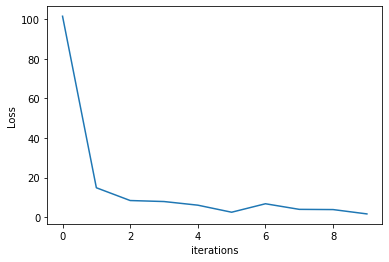

In [32]:
plt.plot(loss_history)
plt.ylabel('Loss')
plt.xlabel('iterations')
plt.show()

# Saving Model to Disk

In [33]:
now = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'model_{now}_loss-{loss_history[-1]:.2f}'
Path(f'./model').mkdir(parents=True, exist_ok=True)
nlp.to_disk(f'./model/{model_name}')

# Loading Model from Disk

In [34]:
model_to_load = model_name;

nlp = spacy.load(f'model/{model_to_load}')

# Testing Model

In [35]:
def get_entities(text):
    doc = nlp(text)
    return [(ent.label_, ent.text) for ent in doc.ents]

In [36]:
examples_to_try = 10
for i in range(examples_to_try):
    random.shuffle(TEST_DATA)
    text, _ = TEST_DATA[i]
    print(text, '\n ', get_entities(text))

160.00 g Grieß 
  [('QUANTITY', '160.00'), ('UNIT', 'g'), ('NAME', 'Grieß')]
1.00 TL Paprikapulver edelsüß 
  [('QUANTITY', '1.00'), ('UNIT', 'TL'), ('NAME', 'Paprikapulver'), ('NAME', 'edelsüß')]
500.00 g Griechischer Joghurt 
  [('QUANTITY', '500.00'), ('UNIT', 'g'), ('NAME', 'Griechischer'), ('NAME', 'Joghurt')]
250.00 g Champignons 
  [('QUANTITY', '250.00'), ('UNIT', 'g'), ('NAME', 'Champignons')]
4.00 Zehen Knoblauch 
  [('QUANTITY', '4.00'), ('UNIT', 'Zehen'), ('NAME', 'Knoblauch')]
1.00 TL Zucker 
  [('QUANTITY', '1.00'), ('UNIT', 'TL'), ('NAME', 'Zucker')]
1.00 Dosen Kichererbsen 
  [('QUANTITY', '1.00'), ('UNIT', 'Dosen'), ('NAME', 'Kichererbsen')]
20.00 g Walnüsse 
  [('QUANTITY', '20.00'), ('UNIT', 'g'), ('NAME', 'Walnüsse')]
100.00 ml Milch 
  [('QUANTITY', '100.00'), ('UNIT', 'ml'), ('NAME', 'Milch')]
2.00 TL Thymian 
  [('QUANTITY', '2.00'), ('UNIT', 'TL'), ('NAME', 'Thymian')]


In [37]:
get_entities('2 tl anis')

[('QUANTITY', '2'), ('UNIT', 'tl'), ('NAME', 'anis')]

# Define a Metric

Different types of metrics can be used:
1. accuracy:
  - `(true positives + true negatives) / total`
  - In other words: correctly predicted / total
  - Question accuracy answers: How many selected items were correctly categorized?
2. recall:
  - `true positives / (true positives + false negatives)`
  - In other words: words correctly identified as entities / all words that are entities
  - Question recall answers: How many relevant items are selected?
3. precision:
  - `true positives / (true positives + false positives)`
  - In other words: words correctly identified as entities / words correctly and incorrectly identified as entities
  - Question precision answers: How many selected items are relevant?
4. F1-score:
  - `2 · precision · recall / (precision + recall)`
  - In other words: It tries to optimize both precision and recall. F1-score 1 means perfect precision and recall. F1-score 0 means either precision or recall is zero.

`Accuracy` can be misleading if we have imbalanced data.

`Recall` is in our case more important than `precision`, since we want to catch all ingredients,
and we don't care if some non-ingredients are marked as such, we can just delete them later in the app with a
single click of a button. On the other hand not recognizing ingredients would force us to type them manually.

We still don't want to have too many non-ingredients in our ingredient's list though, so we could use the `F1-Score`
which combines `recall` and `precision` as a metric for our problem.

Another approach could be to use precision as a **satisficing metric** and recall as an **optimizing metric**.

# Evaluating Model

In [38]:
def evaluate(model, data):
    scorer = Scorer()
    for text, annotations in data:
        doc = model.make_doc(text)
        gold = GoldParse(doc, entities=annotations['entities'])
        prediction = model(text)
        scorer.score(prediction, gold)
        # TODO can I get the wrongly labeled examples from the scorer?
    return scorer.scores['ents_f']

In [39]:
pp('F1 score on TRAIN_DATA', evaluate(nlp, TRAIN_DATA))
pp('F1 score on DEV_DATA', evaluate(nlp, DEV_DATA))
pp('F1 score on TEST_DATA', evaluate(nlp, TEST_DATA))

F1 score on TRAIN_DATA:
100.0

F1 score on DEV_DATA:
99.43019943019942

F1 score on TEST_DATA:
99.72067039106145



# Error Analysis
- train error 1%   - dev error 10% -> bias =   1%, variance = 10%- 1% =   9% -> high variance -> **overfitting**
- train error 15%  - dev error 16% -> bias =  15%, variance = 16%-15% =   1% -> high bias -> **underfitting**
- train error 15%  - dev error 30% -> bias =  15%, variance = 30%-15% =  15% -> high bias and high variance
- train error 0.5% - dev error  1% -> bias = 0.5%, variance = 1%-0.5% = 0.5% -> low bias and low variance
- human error 14% (aka Bayes error rate) - train error 15% - dev error 30% -> avoidable bias = 15%-14% = 1%, variance = 30%-15% = 15% -> low bias and high variance
- if high bias
    - increase model size (neurons, layers)
    - add more features
    - reduce regularization
    - modify model architecture
- if high variance
    - add data to training set
    - add regularization
    - add early stopping
    - remove features (helpful for small datasets)
    - decrease model size

In [40]:
# TODO choose the right hyperparameters using the dev set
# TODO error analysis: get all the mislabeled examples and try to find out what could be the cause. Create an excel table to count which kind of error takes place more frequently.
# TODO calculate bias and variance